In [112]:
import pandas as pd
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [113]:
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
tests_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [114]:
all_features = pd.concat((train_data.iloc[:,1:-1], tests_data.iloc[:, 1:]))
numeric_features_index = (all_features.dtypes[all_features.dtypes != 'object']).index
# 对数化+标准化
all_features[numeric_features_index] = (all_features[numeric_features_index].apply(lambda x: np.log1p(x))).apply(lambda x: (x-x.mean()) / x.std())
all_labels = np.log1p(train_data['SalePrice'])
all_mean_labels = np.mean(all_labels)
all_std_labels = np.std(all_labels)
all_labels = all_labels.apply(lambda x: (x-all_mean_labels) / all_std_labels)
# 缺失值
all_features[numeric_features_index] = all_features[numeric_features_index].fillna(0)
# 离散值
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)

train_features = torch.tensor(all_features[:len(train_data)].values, dtype=torch.float32).to("cuda")
tests_features = torch.tensor(all_features[len(train_data):].values, dtype=torch.float32).to("cuda")

train_labels = (torch.tensor(all_labels, dtype=torch.float32).to("cuda"))
train_labels = train_labels.reshape(train_labels.shape[0], 1)

In [115]:
class Net(nn.Module):
    """Regression Model

    Args:
        nn (nn.Module): PyTorch Module
    """
    def __init__(self):
        """init net struct
        """
        super().__init__()
        self.dropout = nn.Dropout(0.001)
        self.outputs = nn.Linear(all_features.shape[1], 1)
    
    def forward(self, features: torch.Tensor) -> torch.Tensor:
        """前向传播

        Args:
            features (torch.Tensor): features

        Returns:
            torch.Tensor: labels
        """
        return self.outputs(features)

In [116]:
def train(features: torch.Tensor, labels: torch.Tensor, num_epochs: int, lr: float, weight_decay: float, batch_size: int) -> np.array:
    """模型训练

    Args:
        features (torch.Tensor): features
        labels (torch.Tensor): labels
        num_epochs (int): 迭代次数
        lr (float): 学习率
        weight_decay (float): 暂退率
        batch_size (int): 批次大小

    Returns:
        torch.Tensor: 损失
    """
    net   = Net()
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss  = nn.MSELoss()
    
    is_training = net.training
    net.to("cuda")
    
    dataset = torch.utils.data.TensorDataset(features, labels)
    data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_training)
    
    train_losses = []
    
    tqdm_instance = tqdm(range(num_epochs), desc="训练中")
    for _ in tqdm_instance:
        # 训练模式
        net.train()
        train_loss = 0.0
        for X, y in data_loader:
            optim.zero_grad()
            l: torch.Tensor = loss(net(X), y)
            l.backward()
            optim.step()
            train_loss += l.item()
        train_losses.append(train_loss/num_epochs)
        tqdm_instance.set_postfix(loss=train_loss/num_epochs)
    return train_losses

训练中:   0%|          | 0/100 [00:00<?, ?it/s]

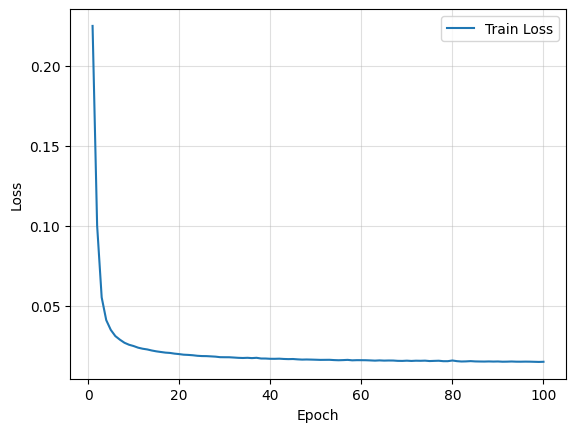

In [117]:
train_losses = train(features=train_features, labels=train_labels, num_epochs=100, lr=0.001, weight_decay=0.001, batch_size=64)

plt.plot(list(range(1, 100+1)), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.4)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# K折交叉验证+网格搜索